#### By: Peyman Shahidi
#### Created: Aug 21, 2025

<br>

In [264]:
#Python
import getpass
import numpy as np
import pandas as pd
from collections import defaultdict
import itertools
import random 

## formatting number to appear comma separated and with two digits after decimal: e.g, 1000 shown as 1,000.00
pd.set_option('float_format', "{:,.2f}".format)

import matplotlib.pyplot as plt
#%matplotlib inline
#from matplotlib.legend import Legend

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200)

In [265]:
main_folder_path = ".."
input_data_path = f"{main_folder_path}/data"
output_data_path = f'{input_data_path}/computed_objects'
output_plot_path = f"{main_folder_path}/writeup/plots"

In [266]:
# Create directories if they don't exist
import os

for path in [output_data_path, output_plot_path]:
    if not os.path.exists(path):
        os.makedirs(path)

In [267]:
# Read O*NET data
onet = pd.read_csv(f'{input_data_path}/onet_occupations_yearly.csv')

# keep 2023 entries only
onet = onet[onet['year'] == 2023].reset_index(drop=True)

# add industry column
onet['ind'] = onet['occ_code'].apply(lambda x: x.split('-')[0] if '-' in x else x)

# remove 's for consistency issues 
onet = onet.applymap(lambda x: x.replace("'", "") if isinstance(x, str) else x)

In [268]:
# Merge SOC groups to 2 digit codes
# Read SOC groups and derive 2 digit codes (from https://www.onetcenter.org/taxonomy/2019/structure.html)
soc_group = pd.read_csv(f'{input_data_path}/SOC_Structure.csv')
soc_group = soc_group[['Major Group', 'SOC or O*NET-SOC 2019 Title']]
soc_group = soc_group.rename(columns={'SOC or O*NET-SOC 2019 Title': 'ind_name', 'Major Group': 'ind'})

# Prepare dataset for the merge
soc_group = soc_group.dropna()
soc_group['ind_name'] = soc_group['ind_name'].str[:-12]
soc_group['ind_name'] = soc_group['ind_name'].str[:50]
soc_group['ind'] = soc_group['ind'].str[:2]

# Merge datasets
onet = pd.merge(onet, soc_group, on='ind', how='left')

In [269]:
# remove duplicates
print(f"Number of rows before removing duplicates: {len(onet)}")
onet = onet.drop_duplicates(subset=['year', 'ind', 'occ_code', 'task_id']).reset_index(drop=True)
print(f"Number of rows after removing duplicates: {len(onet)}")


############################################################################################
################## There's a lot of duplicates that you have to look into ##################
############################################################################################

Number of rows before removing duplicates: 24426
Number of rows after removing duplicates: 19294


In [270]:
# Remove rows where occupation title contains "All Other"
onet = onet[~onet["occ_title"].str.contains("All Other", case=False, na=False)]

### Remove "Teachers"-related occupations

In [271]:
# Filter rows that contain "Teachers" (case-insensitive)
contains_teacher = onet[onet['occ_title'].str.contains('Teachers', case=False, na=False)]

# Step 2: Get the number of unique occupations containing "Teacher"
unique_teacher_occupations = contains_teacher['occ_title'].nunique()
print(f'Number of unique occupations containing the word "Teachers": {unique_teacher_occupations}')

# Remove rows that contain "Teacher" (case-insensitive)
onet = onet[~onet['occ_title'].str.contains('Teachers', case=False, na=False)].reset_index(drop=True)

Number of unique occupations containing the word "Teachers": 49


### Number of Unique Tasks / DWAs / WAs

In [272]:
# Number of unique tasks, DWAs, and WAs
num_unique_tasks = onet['task_id'].nunique()
num_unique_dwas = onet['dwa_id'].nunique()
num_unique_was = onet['wa_id'].nunique()

print(f"Number of unique tasks: {num_unique_tasks}")
print(f"Number of unique DWAs: {num_unique_dwas}")
print(f"Number of unique WAs: {num_unique_was}")

# Function to calculate repetition stats
def calculate_repetition_stats(df, group_cols, id_col, title_col):
    counts = df.groupby(['ind', id_col, title_col]).size().reset_index(name='repetitions')
    counts_filtered = counts[counts['repetitions'] > 1]
    summary_stats = counts_filtered.groupby('ind')['repetitions'].agg(
        min='min',
        p10=lambda x: x.quantile(0.10),
        p25=lambda x: x.quantile(0.25),
        p50=lambda x: x.quantile(0.50),
        p75=lambda x: x.quantile(0.75),
        p90=lambda x: x.quantile(0.90),
        max='max'
    ).reset_index()
    return counts_filtered, summary_stats

# Tasks
task_counts_filtered, task_summary_stats = calculate_repetition_stats(onet, ['ind', 'task_id', 'task'], 'task_id', 'task')

# Detailed Work Activities (DWA)
dwa_counts_filtered, dwa_summary_stats = calculate_repetition_stats(onet, ['ind', 'dwa_id', 'dwa_title'], 'dwa_id', 'dwa_title')

# Work Activities (WA)
wa_counts_filtered, wa_summary_stats = calculate_repetition_stats(onet, ['ind', 'wa_id', 'wa_name'], 'wa_id', 'wa_name')

# Example output
print("\nTask Summary Stats:")
print(task_summary_stats.head())

print("\nDetailed Work Activity Summary Stats:")
print(dwa_summary_stats.head())

print("\nWork Activity Summary Stats:")
print(wa_summary_stats.head())

Number of unique tasks: 16558
Number of unique DWAs: 2061
Number of unique WAs: 37

Task Summary Stats:
Empty DataFrame
Columns: [ind, min, p10, p25, p50, p75, p90, max]
Index: []

Detailed Work Activity Summary Stats:
  ind  min  p10  p25  p50  p75   p90  max
0  11    2 2.00 3.00 5.00 8.00 12.00   39
1  13    2 2.00 4.00 6.00 8.00 10.00   18
2  15    2 2.00 3.00 5.00 7.00 10.00   15
3  17    2 2.00 3.00 5.50 9.00 14.00   29
4  19    2 2.00 3.00 5.50 8.00 10.00   39

Work Activity Summary Stats:
  ind  min  p10   p25   p50   p75   p90  max
0  11    2 3.40  8.00 17.00 45.00 68.00  173
1  13    2 7.70 14.00 24.00 40.25 66.30  101
2  15    3 4.00  8.00 17.00 31.00 54.00  105
3  17    2 4.80  6.25 16.00 49.25 77.40  207
4  19    2 3.00  5.00 14.00 35.00 81.80  182


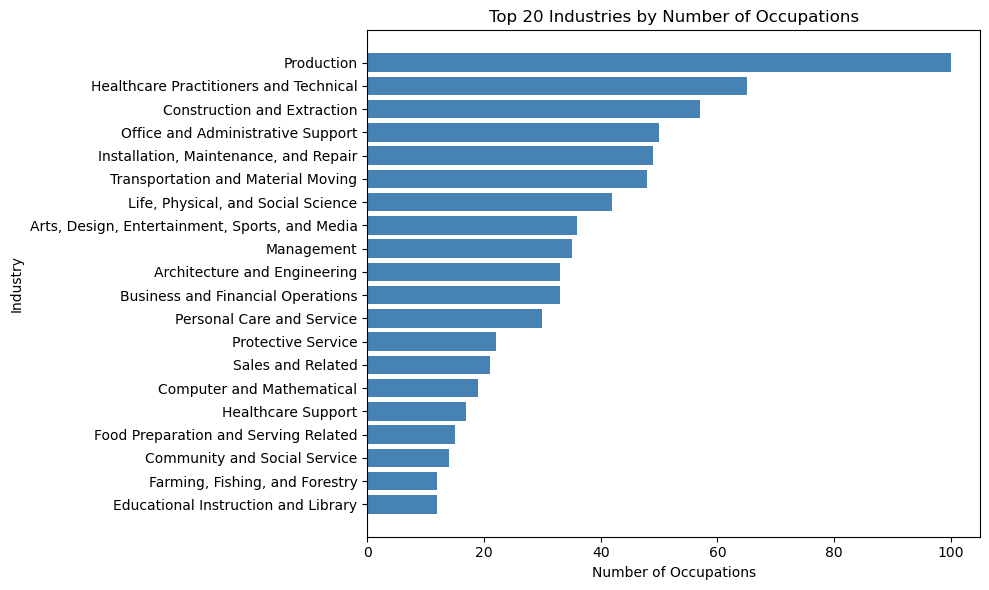

In [273]:
# 1. Number of occupations per industry
occ_per_ind = (
    onet.groupby("ind_name")["occ_title"]
    .nunique()
    .reset_index(name="num_occupations")
    .sort_values("num_occupations", ascending=False)
)

# Save results
occ_per_ind.to_csv(f'{output_data_path}/occupations_per_industry.csv', index=False)

# Plot (top 20 industries)
plt.figure(figsize=(10, 6))
plt.barh(
    occ_per_ind["ind_name"].head(20)[::-1],  # reverse for largest on top
    occ_per_ind["num_occupations"].head(20)[::-1],
    color="steelblue"
)
plt.title("Top 20 Industries by Number of Occupations")
plt.xlabel("Number of Occupations")
plt.ylabel("Industry")
plt.tight_layout()
plt.savefig(f'{output_plot_path}/occupations_per_industry.png')
plt.show()

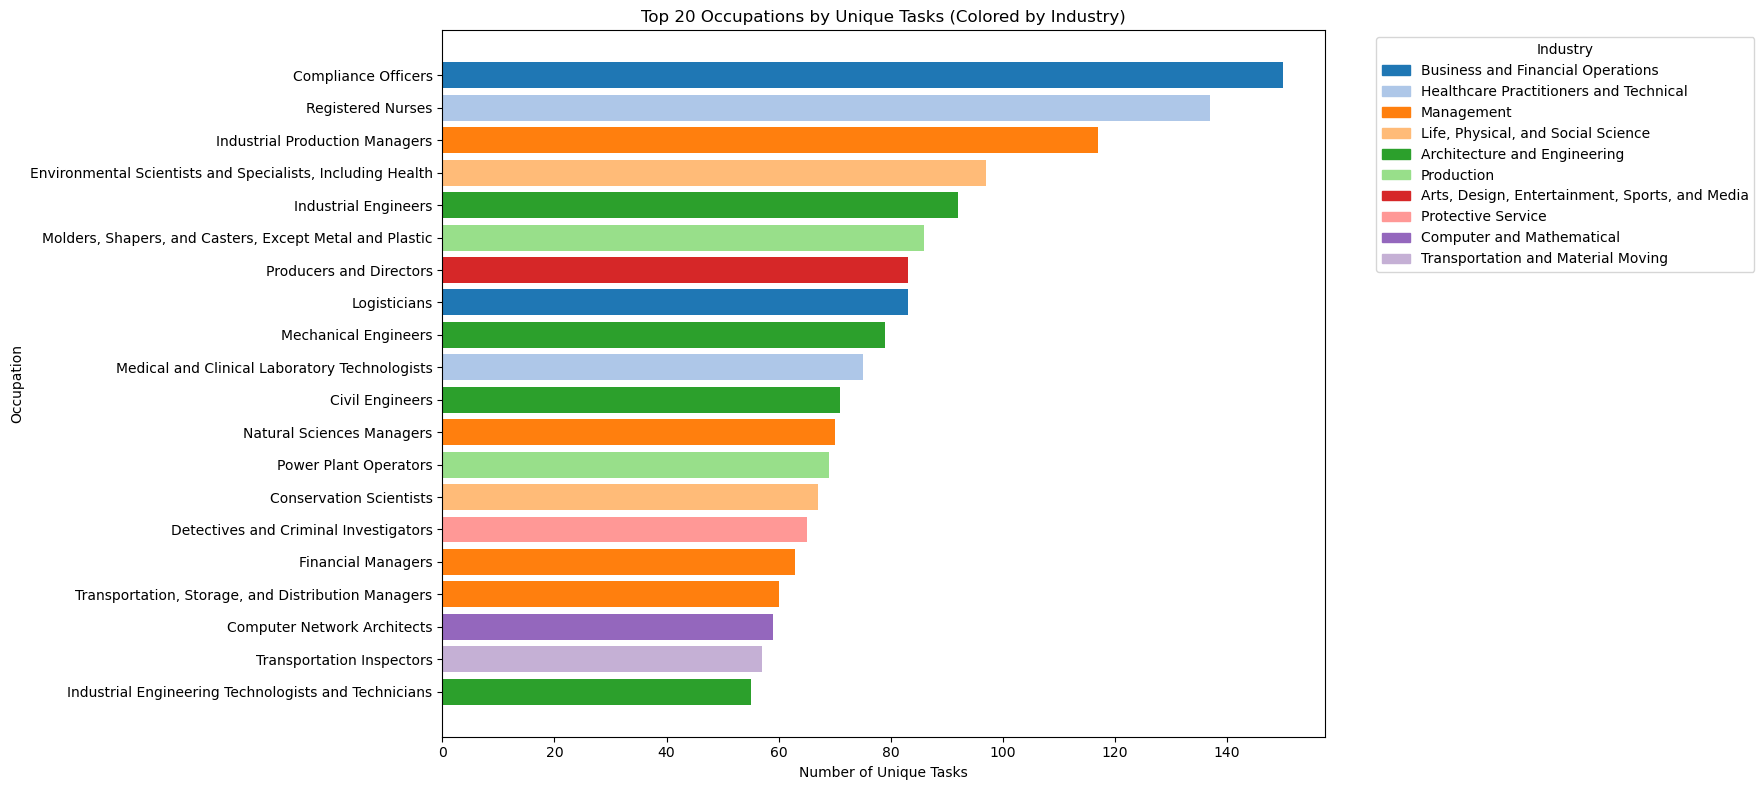

In [274]:
# 2. Number of unique tasks/DWAs/WAs per occupation
tasks_per_occ = (
    onet.groupby(['ind_name', "occ_title"])[["task", "dwa_title", "wa_name"]]
    .nunique()
    .reset_index()
    .rename(columns={
        "task": "num_unique_tasks",
        "dwa_title": "num_unique_DWAs",
        "wa_name": "num_unique_WAs"
    })
    .sort_values("num_unique_tasks", ascending=False)
)

# Save results
tasks_per_occ.to_csv(f'{output_data_path}/unique_tasks_per_occupation.csv', index=False)


# Plot
# Pick top 20 occupations by tasks
top20 = tasks_per_occ.head(20).copy()

plt.figure(figsize=(18, 8))

# Assign unique color per industry
industries = top20["ind_name"].unique()
colors = plt.cm.tab20.colors  # 20 distinct colors
color_map = {ind: colors[i % len(colors)] for i, ind in enumerate(industries)}

# Reverse order so largest is at the top
y_labels = top20["occ_title"].iloc[::-1]
x_vals   = top20["num_unique_tasks"].iloc[::-1]
inds     = top20["ind_name"].iloc[::-1]

bars = plt.barh(y_labels, x_vals, color=[color_map[ind] for ind in inds])

# Title and labels
plt.title("Top 20 Occupations by Unique Tasks (Colored by Industry)")
plt.xlabel("Number of Unique Tasks")
plt.ylabel("Occupation")

# Legend for industries
legend_patches = [plt.Rectangle((0,0),1,1, color=color_map[ind]) for ind in industries]
plt.legend(legend_patches, industries, title="Industry", 
           bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.savefig(f"{output_plot_path}/unique_tasks_per_occupation_by_industry.png")
plt.show()


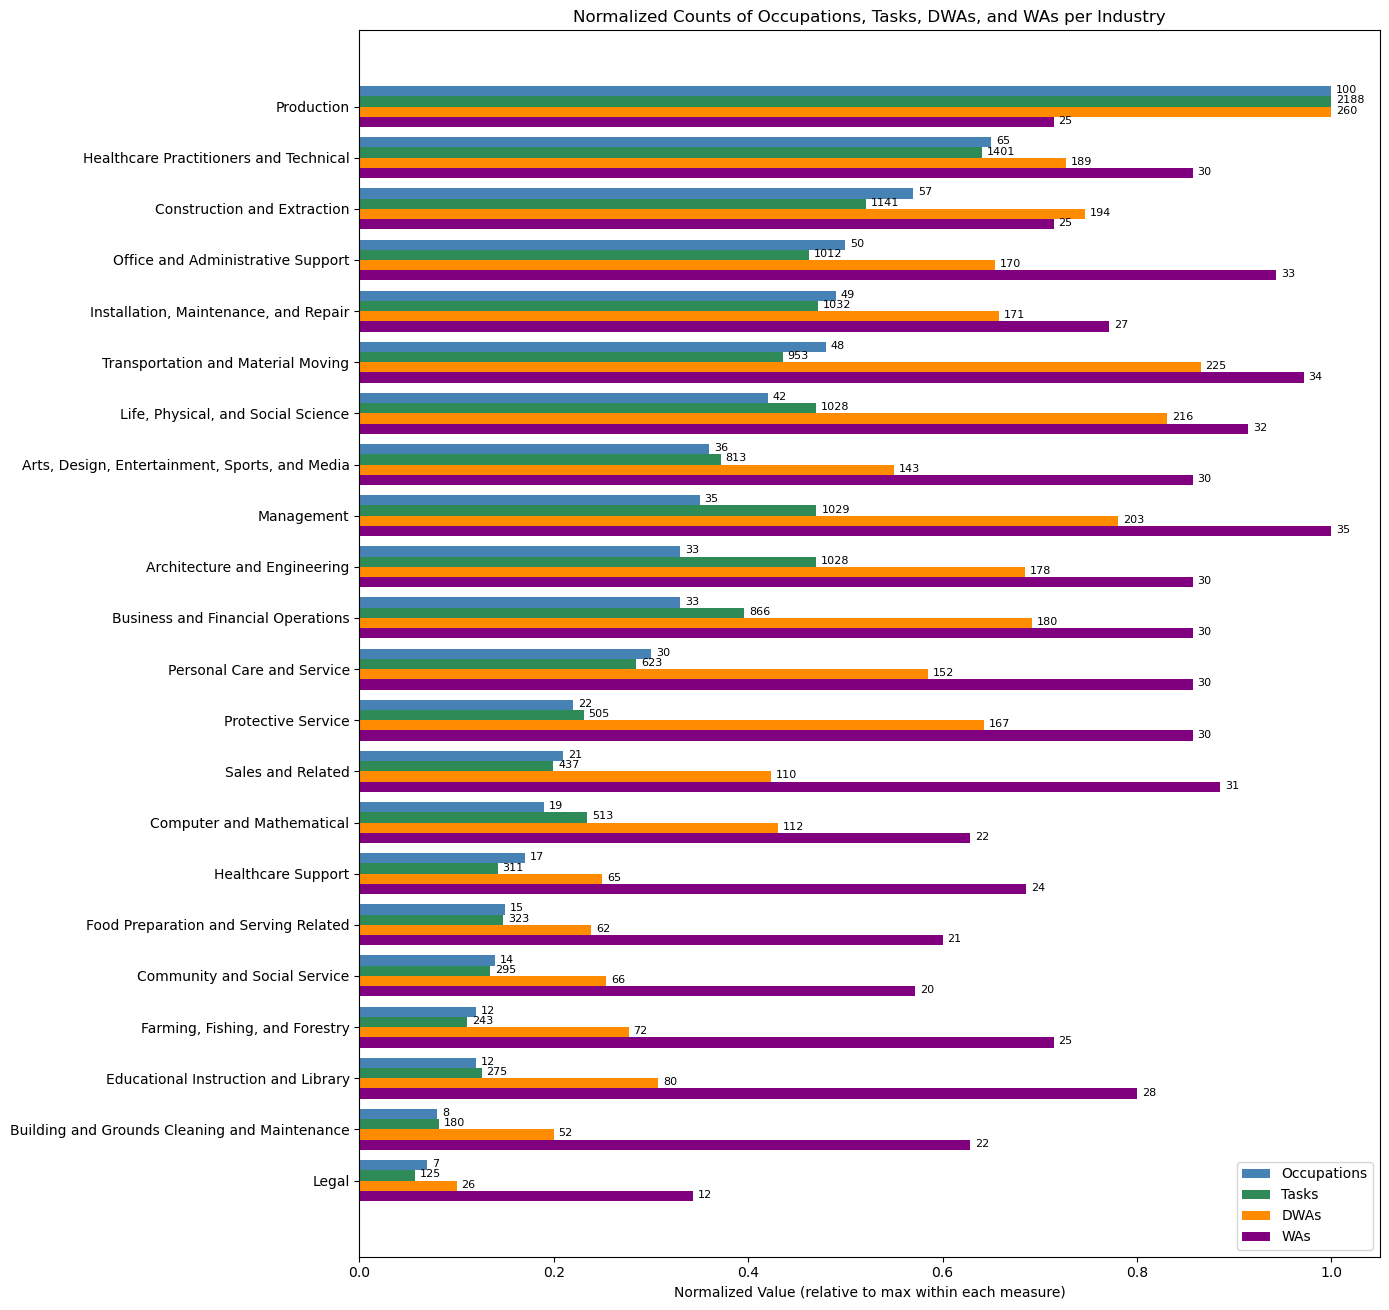

In [310]:
import numpy as np
import matplotlib.pyplot as plt

# --- Compute absolute counts per industry ---
jobs_tasks_abs = (
    onet.groupby("ind_name")
    .agg(
        num_unique_occ=("occ_title", "nunique"),
        num_unique_tasks=("task", "nunique"),
        num_unique_DWAs=("dwa_title", "nunique"),
        num_unique_WAs=("wa_name", "nunique"),
    )
    .reset_index()
)

# Normalize values within each measure
normed = jobs_tasks_abs.copy()
normed["occ_norm"]   = normed["num_unique_occ"]   / normed["num_unique_occ"].max()
normed["tasks_norm"] = normed["num_unique_tasks"] / normed["num_unique_tasks"].max()
normed["DWAs_norm"]  = normed["num_unique_DWAs"]  / normed["num_unique_DWAs"].max()
normed["WAs_norm"]   = normed["num_unique_WAs"]   / normed["num_unique_WAs"].max()

# Sort industries by number of occupations (or whichever measure you prefer)
normed = normed.sort_values("num_unique_occ", ascending=False)

# --- Grouped bar plot (normalized, with raw counts as labels) ---
ind = np.arange(len(normed))  # y positions
bar_height = 0.2

fig, ax = plt.subplots(figsize=(14, 0.6 * len(normed)))

bars_occ  = ax.barh(ind - bar_height*1.5, normed["occ_norm"],   height=bar_height, color="steelblue", label="Occupations")
bars_task = ax.barh(ind - bar_height*0.5, normed["tasks_norm"], height=bar_height, color="seagreen",  label="Tasks")
bars_dwa  = ax.barh(ind + bar_height*0.5, normed["DWAs_norm"],  height=bar_height, color="darkorange",label="DWAs")
bars_wa   = ax.barh(ind + bar_height*1.5, normed["WAs_norm"],   height=bar_height, color="purple",    label="WAs")

# Labels and ticks
ax.set_yticks(ind)
ax.set_yticklabels(normed["ind_name"])
ax.invert_yaxis()
ax.set_title("Normalized Counts of Occupations, Tasks, DWAs, and WAs per Industry")
ax.set_xlabel("Normalized Value (relative to max within each measure)")
ax.legend()

# Annotate bars with real (unnormalized) counts
for bars, vals in [
    (bars_occ,  normed["num_unique_occ"]),
    (bars_task, normed["num_unique_tasks"]),
    (bars_dwa,  normed["num_unique_DWAs"]),
    (bars_wa,   normed["num_unique_WAs"]),
]:
    for bar, val in zip(bars, vals):
        ax.text(bar.get_width() + 0.005,  # offset so it doesn't overlap
                bar.get_y() + bar.get_height()/2.5,
                str(val), va="center", fontsize=8)

plt.tight_layout()
plt.savefig(f"{output_plot_path}/jobs_tasks_dwas_was_absolute_normalized.png")
plt.show()

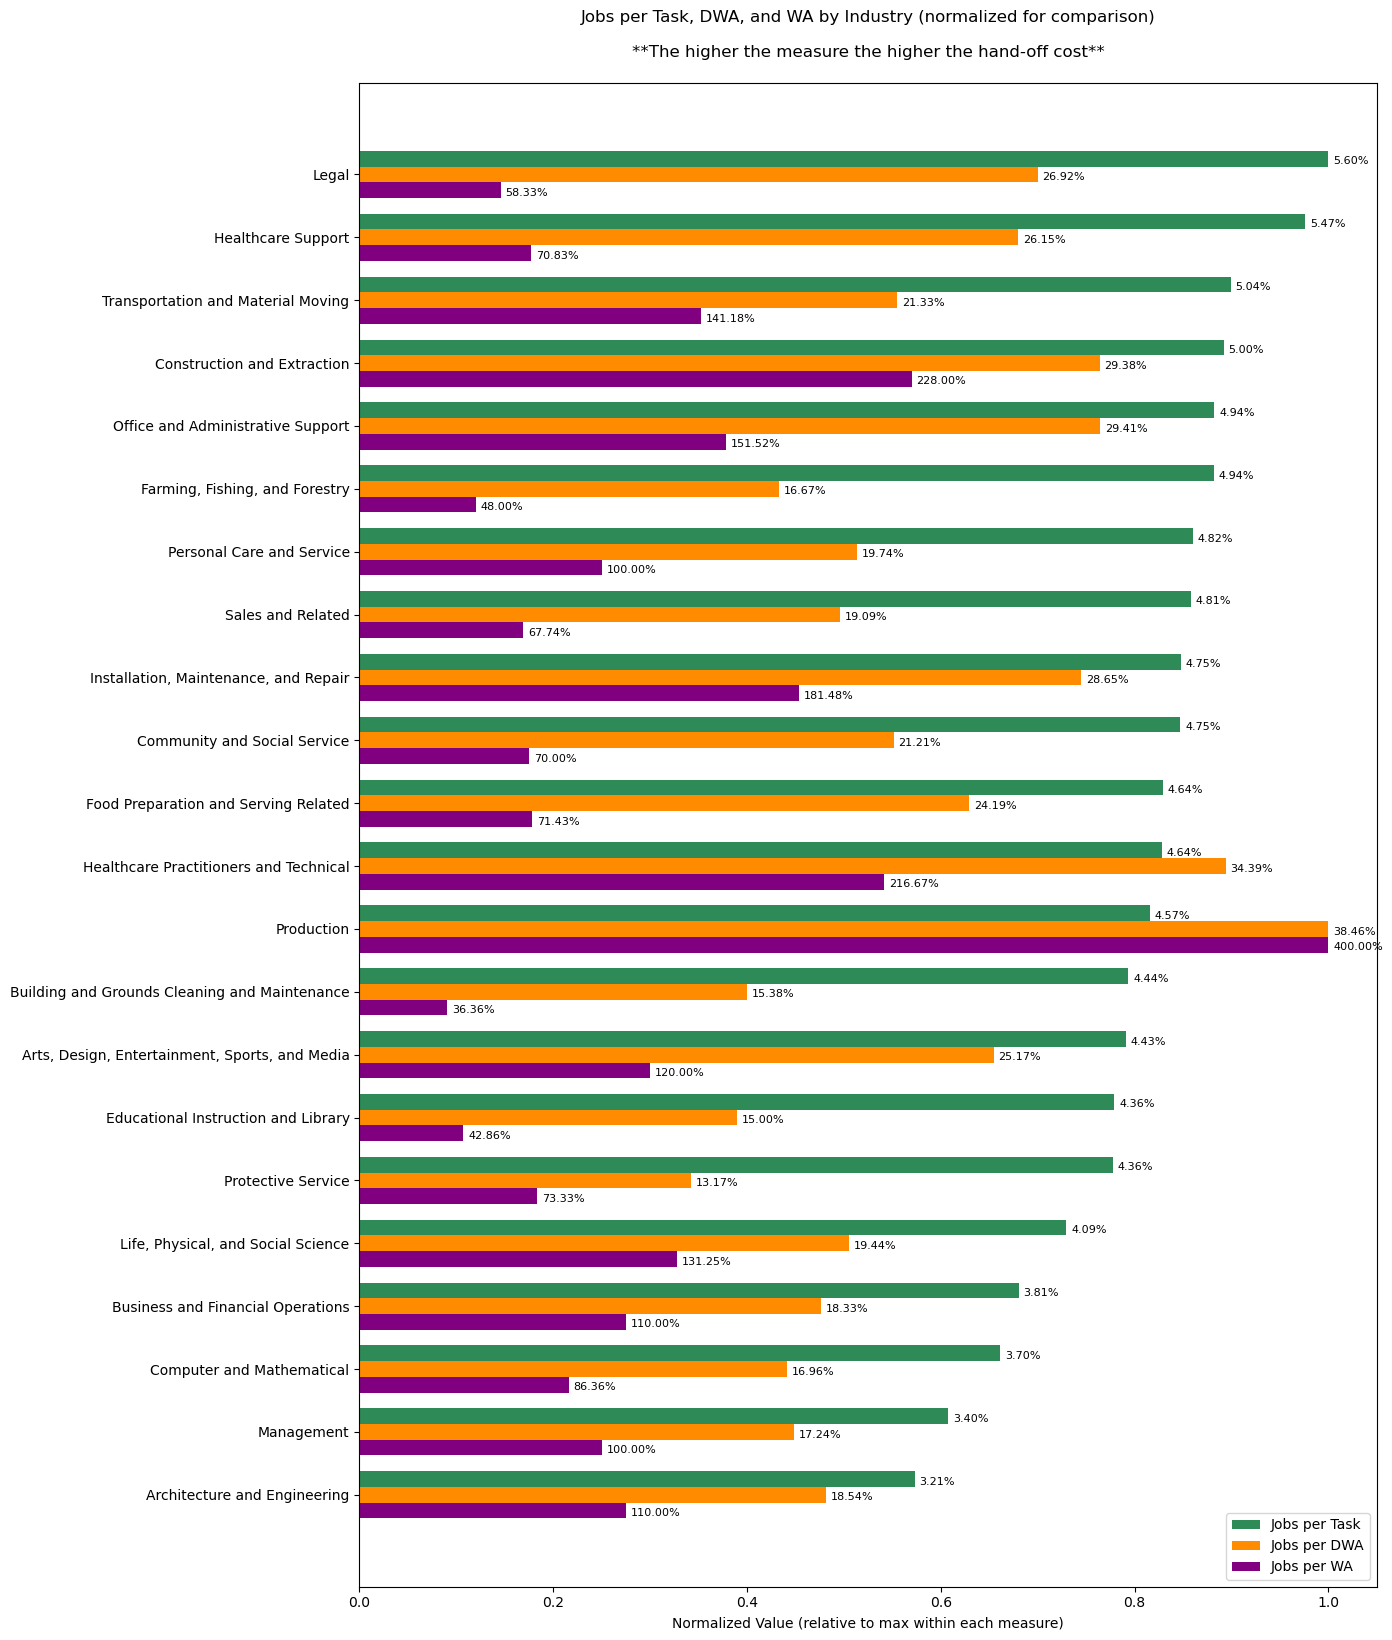

In [302]:
import numpy as np
import matplotlib.pyplot as plt

# --- Compute measure as before ---
jobs_tasks_ratio = (
    onet.groupby("ind_name")
    .agg(
        num_unique_occ=("occ_title", "nunique"),
        num_unique_tasks=("task", "nunique"),
        num_unique_DWAs=("dwa_title", "nunique"),
        num_unique_WAs=("wa_name", "nunique"),
    )
    .reset_index()
)

# Ratios (as percentages)
jobs_tasks_ratio["jobs_per_task"] = (
    jobs_tasks_ratio["num_unique_occ"] / jobs_tasks_ratio["num_unique_tasks"] * 100
)
jobs_tasks_ratio["jobs_per_DWA"] = (
    jobs_tasks_ratio["num_unique_occ"] / jobs_tasks_ratio["num_unique_DWAs"] * 100
)
jobs_tasks_ratio["jobs_per_WA"] = (
    jobs_tasks_ratio["num_unique_occ"] / jobs_tasks_ratio["num_unique_WAs"] * 100
)

# Sort industries by jobs_per_task (main metric)
jobs_tasks_ratio = jobs_tasks_ratio.sort_values("jobs_per_task", ascending=False)

# --- Normalize values for plotting ---
normed = jobs_tasks_ratio.copy()
normed["jobs_per_task_norm"] = normed["jobs_per_task"] / normed["jobs_per_task"].max()
normed["jobs_per_DWA_norm"]  = normed["jobs_per_DWA"]  / normed["jobs_per_DWA"].max()
normed["jobs_per_WA_norm"]   = normed["jobs_per_WA"]   / normed["jobs_per_WA"].max()

# --- Grouped bar plot ---
ind = np.arange(len(normed))  # y positions
bar_height = 0.25

fig, ax = plt.subplots(figsize=(14, 0.75 * len(normed)))

# Bars
bars_task = ax.barh(ind - bar_height, normed["jobs_per_task_norm"], height=bar_height, color="seagreen", label="Jobs per Task")
bars_dwa  = ax.barh(ind, normed["jobs_per_DWA_norm"], height=bar_height, color="darkorange", label="Jobs per DWA")
bars_wa   = ax.barh(ind + bar_height, normed["jobs_per_WA_norm"], height=bar_height, color="purple", label="Jobs per WA")

# Labels and ticks
ax.set_yticks(ind)
ax.set_yticklabels(normed["ind_name"])
ax.invert_yaxis()  # highest values at top
ax.set_title("Jobs per Task, DWA, and WA by Industry (normalized for comparison)\n\n**The higher the measure the higher the hand-off cost**\n")
ax.set_xlabel("Normalized Value (relative to max within each measure)")
ax.legend()

# Annotate bars with real (unnormalized) values
for bars, vals in [
    (bars_task, normed["jobs_per_task"]),
    (bars_dwa, normed["jobs_per_DWA"]),
    (bars_wa, normed["jobs_per_WA"]),
]:
    for bar, val in zip(bars, vals):
        ax.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/1.5,
                f"{val:.2f}%", va="center", fontsize=8)

plt.tight_layout()
plt.savefig(f"{output_plot_path}/jobs_per_task_dwa_wa_grouped_normalized.png")
plt.show()

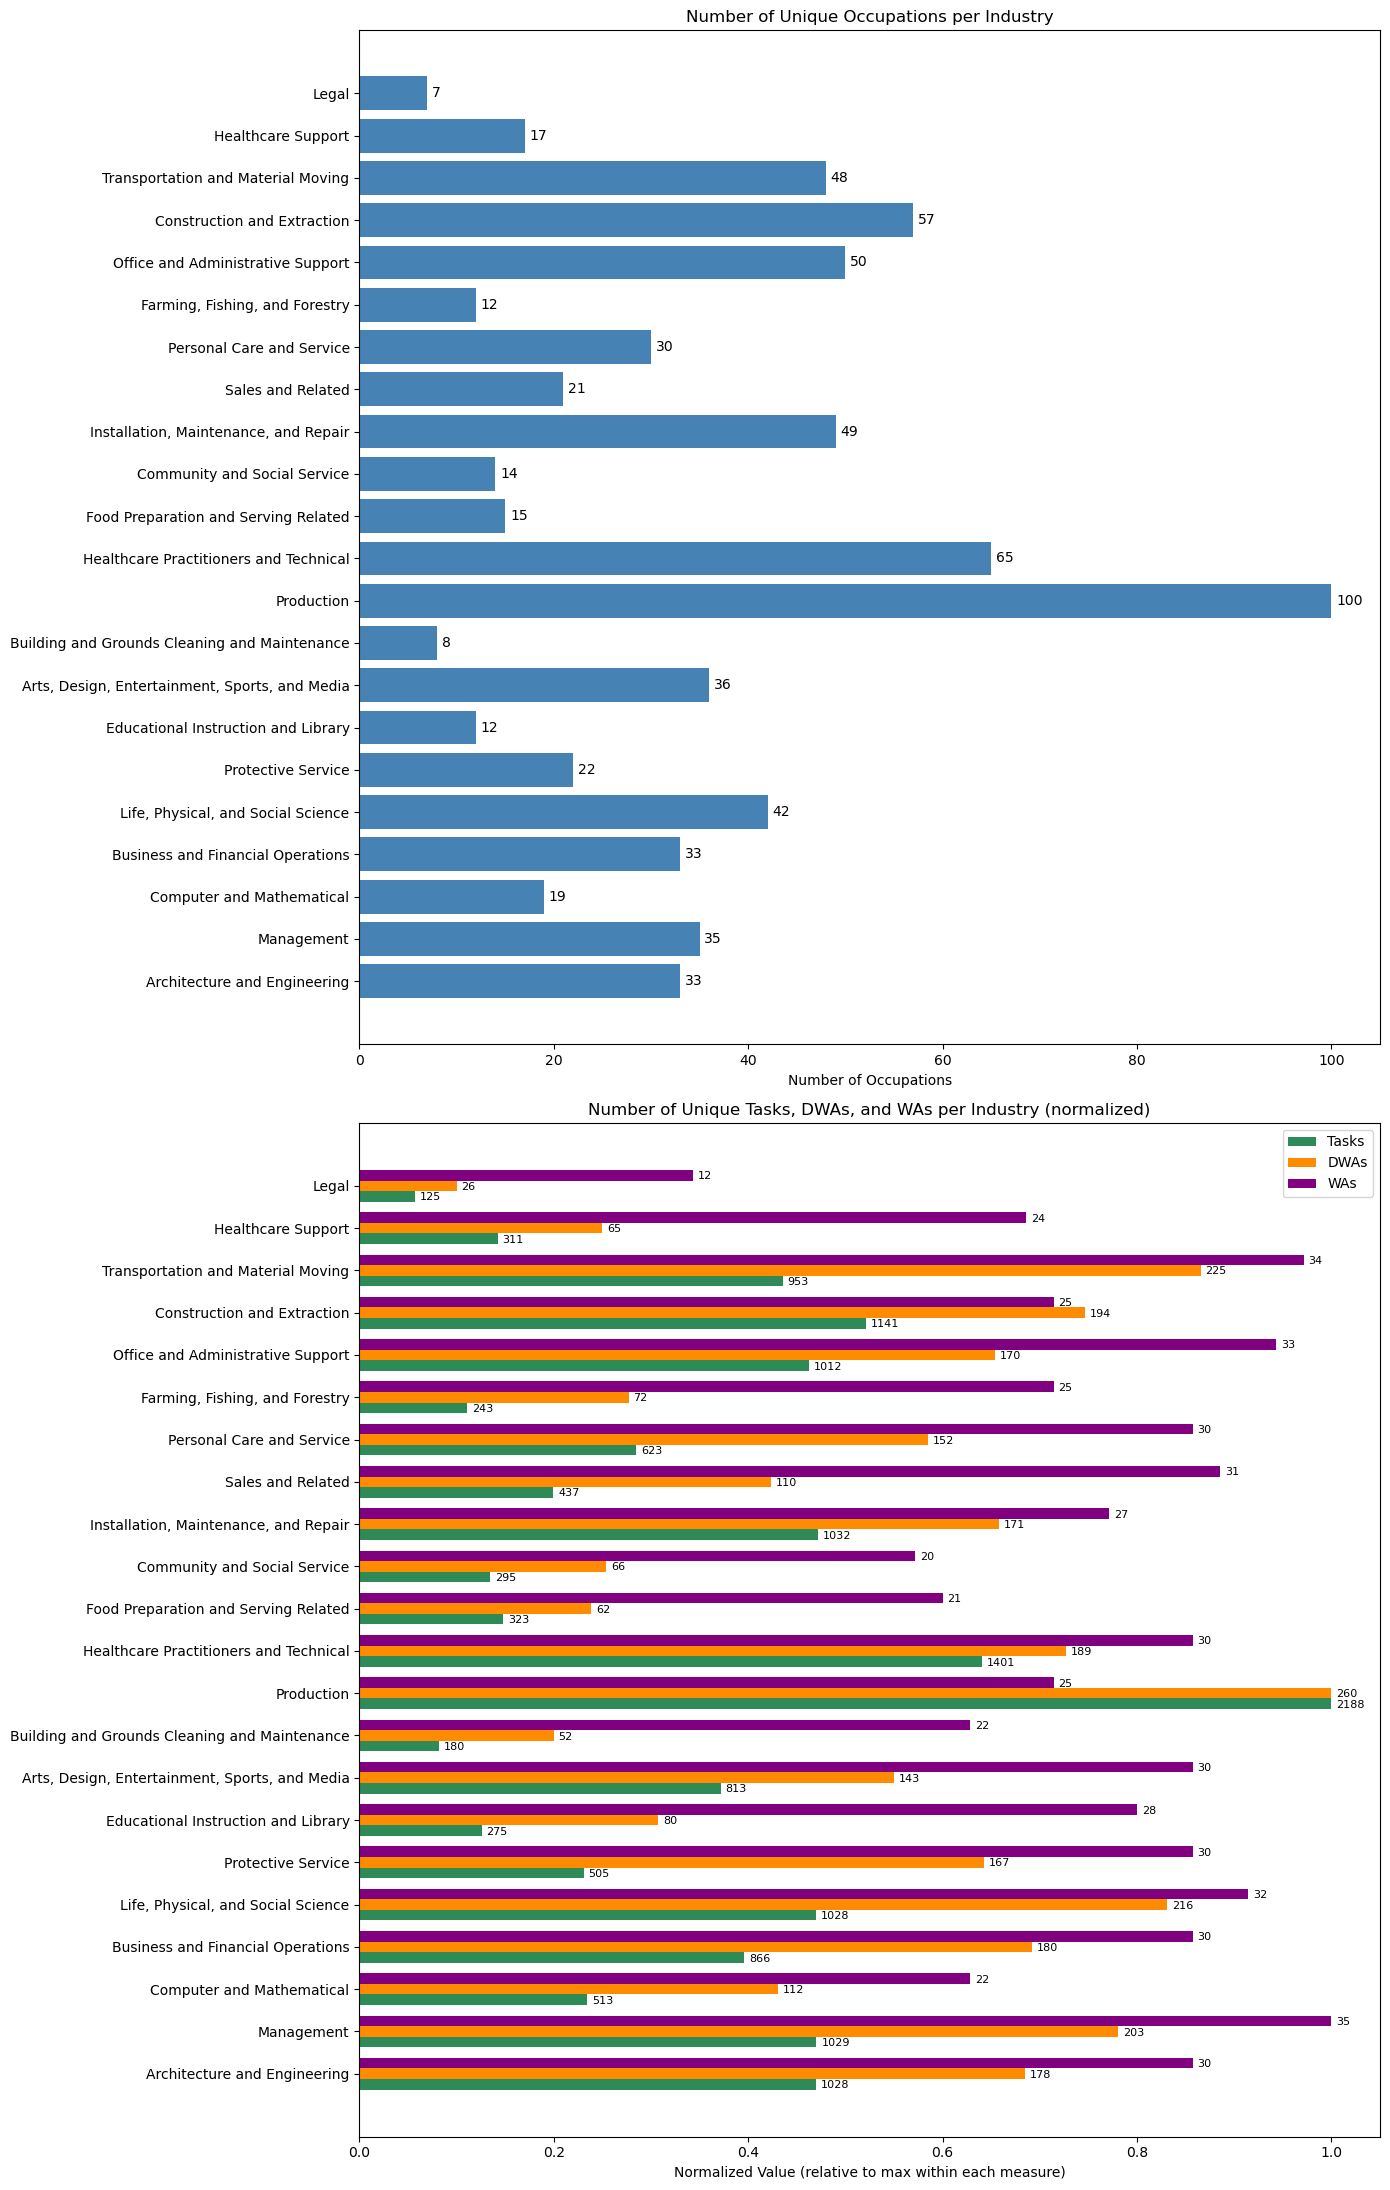

In [307]:
import numpy as np
import matplotlib.pyplot as plt

# --- Compute measure as before ---
jobs_tasks_ratio = (
    onet.groupby("ind_name")
    .agg(
        num_unique_occ=("occ_title", "nunique"),
        num_unique_tasks=("task", "nunique"),
        num_unique_DWAs=("dwa_title", "nunique"),
        num_unique_WAs=("wa_name", "nunique"),
    )
    .reset_index()
)

jobs_tasks_ratio["jobs_per_task"] = (
    jobs_tasks_ratio["num_unique_occ"] / jobs_tasks_ratio["num_unique_tasks"]
)

# Sort industries by jobs_per_task
jobs_tasks_ratio = jobs_tasks_ratio.sort_values("jobs_per_task", ascending=True)

# --- Normalize for grouped plot ---
normed = jobs_tasks_ratio.copy()
normed["tasks_norm"] = normed["num_unique_tasks"] / normed["num_unique_tasks"].max()
normed["DWAs_norm"]  = normed["num_unique_DWAs"] / normed["num_unique_DWAs"].max()
normed["WAs_norm"]   = normed["num_unique_WAs"] / normed["num_unique_WAs"].max()

# --- Plot: Occupations (first) + grouped Tasks/DWAs/WAs (normalized) ---
fig, axes = plt.subplots(2, 1, figsize=(14, 0.5 * len(jobs_tasks_ratio) * 2), sharey=True)

# 1. Occupations (raw counts, unchanged)
bars_occ = axes[0].barh(
    jobs_tasks_ratio["ind_name"],
    jobs_tasks_ratio["num_unique_occ"],
    color="steelblue"
)
axes[0].set_title("Number of Unique Occupations per Industry")
axes[0].set_xlabel("Number of Occupations")
for bar, val in zip(bars_occ, jobs_tasks_ratio["num_unique_occ"]):
    axes[0].text(val + 0.5, bar.get_y() + bar.get_height()/2, str(val), va="center")

# 2. Grouped (normalized) Tasks / DWAs / WAs
ind = np.arange(len(normed))
bar_height = 0.25

bars_task = axes[1].barh(ind - bar_height, normed["tasks_norm"], height=bar_height, color="seagreen", label="Tasks")
bars_dwa  = axes[1].barh(ind,             normed["DWAs_norm"],  height=bar_height, color="darkorange", label="DWAs")
bars_wa   = axes[1].barh(ind + bar_height, normed["WAs_norm"],   height=bar_height, color="purple", label="WAs")

axes[1].set_yticks(ind)
axes[1].set_yticklabels(normed["ind_name"])
axes[1].set_title("Number of Unique Tasks, DWAs, and WAs per Industry (normalized)")
axes[1].set_xlabel("Normalized Value (relative to max within each measure)")
axes[1].legend()

# Annotate with actual numbers (not normalized)
for bars, vals in [
    (bars_task, normed["num_unique_tasks"]),
    (bars_dwa, normed["num_unique_DWAs"]),
    (bars_wa, normed["num_unique_WAs"]),
]:
    for bar, val in zip(bars, vals):
        axes[1].text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2.5,
                     str(val), va="center", fontsize=8)

plt.tight_layout()
plt.savefig(f"{output_plot_path}/jobs_tasks_dwas_was_grouped_normalized_by_industry.png")
plt.show()